Utilizando el dataset de señas de manos, crear una red neuronal con caracteristicas similares a las vistas en clase y entrenarla hasta obtener un accuracy de, como minimo, 85% evitando sobreentrenamiento. Aplicar las técnicas de data augmentation que consideren necesarias.

---
El dataset es un conjunto de imagenes de una mano realizando figuras de numeros del 0 al 5. El objetivo es clasificar a que digito corresponde cada imagen.

<img src="./SIGNS.png" style="width:800px">

Para cargar en memoria el dataset suministrado pueden utilizar la siguiente función:

In [1]:
# pip install cython
# sudo apt-get install libhdf5-dev
# pip install h5py

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    train_x = np.array(train_dataset["train_set_x"][:])
    train_y = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('test_signs.h5', "r")
    test_x = np.array(test_dataset["test_set_x"][:])
    test_y = np.array(test_dataset["test_set_y"][:])

    classes = np.array(test_dataset["list_classes"][:])
    
    train_y = train_y.reshape((train_y.shape[0]))
    test_y = test_y.reshape((test_y.shape[0]))
    
    return train_x, train_y, test_x, test_y, classes

El conjunto de entrenamiento tiene 1080 imágenes
El conjunto de testeo tiene 120 imágenes
Las imágenes son de: (64, 64, 3)
Label de la imágen 0: 5
Label de la imágen 1: 0
Label de la imágen 2: 2
Label de la imágen 3: 5
Label de la imágen 4: 2
Label de la imágen 5: 4
Label de la imágen 6: 2
Label de la imágen 7: 1
Label de la imágen 8: 1


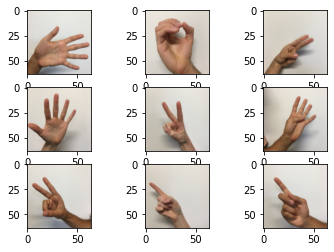

In [4]:
train_x, train_y, test_x, test_y, classes = load_dataset()

print("El conjunto de entrenamiento tiene {} imágenes".format(len(train_x)))
print("El conjunto de testeo tiene {} imágenes".format(len(test_x)))
print("Las imágenes son de: {}".format(train_x[0].shape))

# Ploteo algunas imagenes del dataset y sus etiquetas
for i in range(9):

  plt.subplot(331 + i)
  plt.imshow(train_x[i], cmap=plt.get_cmap('gray'))
  print("Label de la imágen {}: {}".format(i, train_y[i]))

plt.show()

In [5]:
# Readaptamos las etiquetas para que queden en formato one-hot.
train_y = tf.one_hot(train_y, 6)
test_y = tf.one_hot(test_y, 6)

2021-11-13 14:21:07.911616: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-11-13 14:21:07.940192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 14:21:07.940353: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro M1200 computeCapability: 5.0
coreClock: 1.148GHz coreCount: 5 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 74.65GiB/s
2021-11-13 14:21:07.940516: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-11-13 14:21:07.941801: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-11-13 14:21:07.943081: I tensorflow/stream_executor/platform/default

In [6]:
# Dado que las imágenes contienen pixeles con valores en el rango de 0 a 255, realizamos una normalización para llevarlas al rango 0 a 1.
train_x = train_x / 255.0
test_x = test_x / 255.0

In [7]:
# Creamos un conjunto de validación de 5000 muestras a partir del conjunto de entrenamiento.
valid_x = train_x[:150]
valid_y = train_y[:150]

In [8]:
# Creación de la Red Neuronal
lenet5_model = tf.keras.Sequential([
    
    # tf.keras.layers.Input(shape=(32, 32, 1)),
    tf.keras.layers.Input(shape=(64, 64, 3)),
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding="valid", activation="tanh"),
    tf.keras.layers.AveragePooling2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, padding="valid", activation="tanh"),
    tf.keras.layers.AveragePooling2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(filters=120, kernel_size=5, strides=1, padding="valid", activation="tanh"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=84, activation="tanh"),
    tf.keras.layers.Dense(units=6, activation="softmax")
])

lenet5_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 6)         456       
_________________________________________________________________
average_pooling2d (AveragePo (None, 30, 30, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 120)         48120     
_________________________________________________________________
flatten (Flatten)            (None, 9720)              0         
_________________________________________________________________
dense (Dense)                (None, 84)                8

In [16]:
# Una vez creada la arquitectura de la red, debemos "compilar" el modelo e indicarle que optimizador, función de error y metricas utilizar durante el entrenamiento, entre otras cosas.
lenet5_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [17]:
lenet5_history = lenet5_model.fit(x=train_x,
                                  y=train_y,
                                  batch_size=64,
                                  epochs=100,
                                  validation_data=(valid_x, valid_y),
                                  callbacks=[tf.keras.callbacks.TensorBoard(), tf.keras.callbacks.ModelCheckpoint('./')])

2021-11-13 14:51:49.322145: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2021-11-13 14:51:49.322240: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1408] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-11-13 14:51:49.322318: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1447] function cupti_interface_->ActivityRegisterCallbacks( AllocCuptiActivityBuffer, FreeCuptiActivityBuffer)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-11-13 14:51:49.322340: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1430] function cupti_interface_->EnableCallback( 0 , subscriber_, CUPTI_CB_DOMAIN_DRIVER_API, cbid)failed with error CUPTI_ERROR_INVALID_PARAMETER


Epoch 1/100
 8/17 [=============>................] - ETA: 0s - loss: 1.7629 - categorical_accuracy: 0.2949

2021-11-13 14:51:49.718214: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2021-11-13 14:51:49.718279: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1408] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-11-13 14:51:49.718340: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1447] function cupti_interface_->ActivityRegisterCallbacks( AllocCuptiActivityBuffer, FreeCuptiActivityBuffer)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-11-13 14:51:49.743233: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1430] function cupti_interface_->EnableCallback( 0 , subscriber_, CUPTI_CB_DOMAIN_DRIVER_API, cbid)failed with error CUPTI_ERROR_INVALID_PARAMETER
2021-11-13 14:51:49.743443: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:216]  GpuTracer has collected 0 callback api events and 0 activity events.
2021-11-13 14:51:49.744189: I ten

17/17 [==============================] - 1s 67ms/step - loss: 1.7623 - categorical_accuracy: 0.2917 - val_loss: 1.7548 - val_categorical_accuracy: 0.2733
Epoch 2/100
17/17 [==============================] - 1s 53ms/step - loss: 1.7591 - categorical_accuracy: 0.2639 - val_loss: 1.7541 - val_categorical_accuracy: 0.3000
Epoch 3/100
17/17 [==============================] - 1s 61ms/step - loss: 1.7566 - categorical_accuracy: 0.3176 - val_loss: 1.7501 - val_categorical_accuracy: 0.3533
Epoch 4/100
17/17 [==============================] - 1s 49ms/step - loss: 1.7526 - categorical_accuracy: 0.3250 - val_loss: 1.7470 - val_categorical_accuracy: 0.3733
Epoch 5/100
17/17 [==============================] - 1s 51ms/step - loss: 1.7494 - categorical_accuracy: 0.3370 - val_loss: 1.7425 - val_categorical_accuracy: 0.4000
Epoch 6/100
17/17 [==============================] - 1s 48ms/step - loss: 1.7466 - categorical_accuracy: 0.3259 - val_loss: 1.7406 - val_categorical_accuracy: 0.4200
Epoch 7/100
17/1

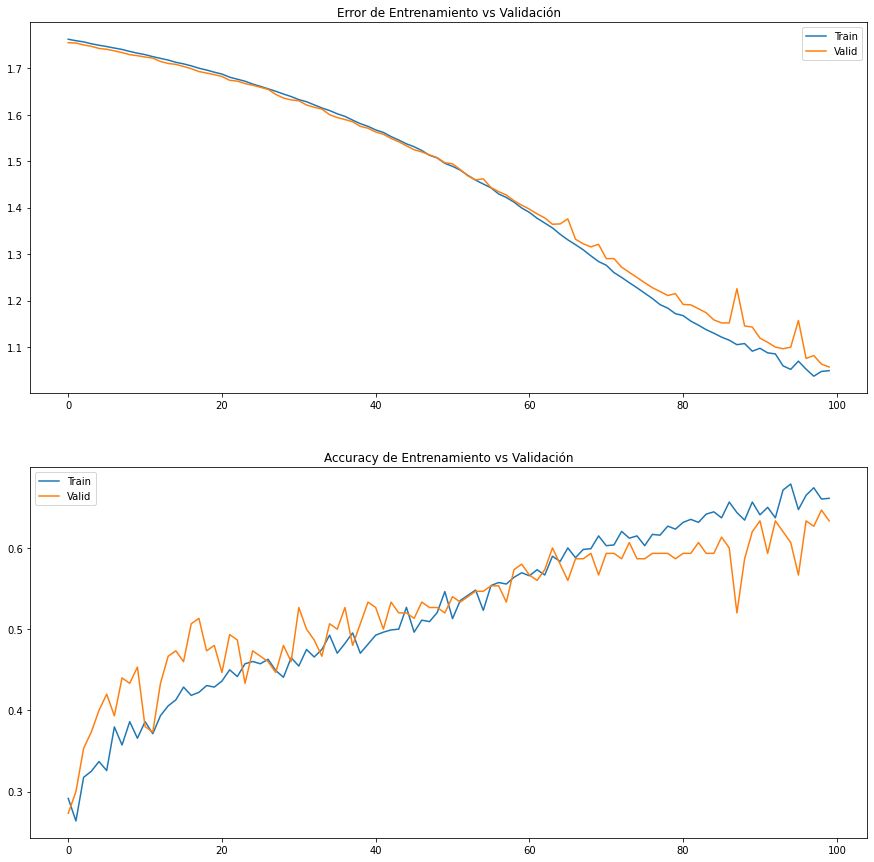

In [18]:
# Visualización de los resultados

fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(lenet5_history.history['loss']) 
axs[0].plot(lenet5_history.history['val_loss']) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(lenet5_history.history['categorical_accuracy']) 
axs[1].plot(lenet5_history.history['val_categorical_accuracy']) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

## TensorBoard

Otra forma de visualizar los resultados del entrenamiento de nuestra red es mediante la herramienta TensorBoard, la cual forma parte del framework de Tensorflow. Esta herramienta nos permite ver graficas interactivas de la evolución de las distintas metricas a lo largo de las epocas o las iteraciones de entrenamiento, así como también un grafo de las conexiones que componen nuestro modelo, entre otras cosas.

In [14]:
# %load_ext tensorboard
# %tensorboard --logdir logs

## Evaluación del modelo

Una vez entrenado el modelo, podemos evaluarlo con el conjunto de test mediante la funcion evaluate.

In [19]:
results = lenet5_model.evaluate(test_x, test_y)

print("El modelo logro un error de {} y una accuracy de {}".format(results[0], results[1]))

4/4 [==============================] - 0s 5ms/step - loss: 1.0504 - categorical_accuracy: 0.6917
El modelo logro un error de 1.0504202842712402 y una accuracy de 0.6916666626930237
